# Libraries

In [74]:
import numpy as np
import pandas as pd
import pymol as pm
from findseq import findseq
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(font_scale = 2, rc={'figure.figsize':(15,12)})

# Torsion angles

In [100]:
structs = pd.read_csv('structs.csv')

In [101]:
problems_resi = pd.read_csv('problems_resi.csv')
problems_CA = pd.read_csv('problems_CA.csv')

In [77]:
fname = 'pdb/'                                                                                                                                                               
ex = '.cif'

angles = pd.DataFrame()
problems = set()

for i in tqdm(range(0, len(structs))):
    row = dict(structs.iloc[i])
    
    ID = row['ID']
    name = row['pdb_name'].lower()
    chain = row['chain']
    seq = row['sequence']
    
#     if name in ['1p9h', '1gq8', '6zt4', '6n2c']:
#         continue
    
    pm.api.load(fname + name + ex, quiet=1) 
    
    pm.api.select('s', f'{name}/{chain}///', quiet=1)  
    
    findseq(seq, 's', 'seq')
    
    resi = []                                                                                                                                                       
    atoms = pm.api.get_model('seq')                                                                                                                                
    for at in atoms.atom:                                                                                                                                           
        resi.append(int(at.resi))
    
    if resi == []:
        continue
    
    MIN = min(resi)                                                                                                                                                
    MAX = max(resi)
    
    interval = [MIN+1, MIN+2, MAX-2, MAX-1]  
    
    # psi для первого
    
    try:
        pm.api.select('atom1', f'{name}/{chain}//{MIN}/n', quiet=1)  
        pm.api.select('atom2', f'{name}/{chain}//{MIN}/ca', quiet=1)  
        pm.api.select('atom3', f'{name}/{chain}//{MIN}/c', quiet=1)  
        pm.api.select('atom4', f'{name}/{chain}//{MIN+1}/n', quiet=1)  
        
        row['psi1'] = pm.api.get_dihedral('atom1','atom2','atom3','atom4')

        pm.api.delete('atom1')
        pm.api.delete('atom2')
        pm.api.delete('atom3')
        pm.api.delete('atom4')
        
        for i in range(4):
            pos = interval[i]

            # phi

            pm.api.select('atom1', f'{name}/{chain}//{pos-1}/ca', quiet=1)  
            pm.api.select('atom2', f'{name}/{chain}//{pos}/n', quiet=1)  
            pm.api.select('atom3', f'{name}/{chain}//{pos}/ca', quiet=1)  
            pm.api.select('atom4', f'{name}/{chain}//{pos}/c', quiet=1)  

            row[f'phi{i+2}'] = pm.api.get_dihedral('atom1','atom2','atom3','atom4')

            # psi

            pm.api.select('atom1', f'{name}/{chain}//{pos}/n', quiet=1)  
            pm.api.select('atom2', f'{name}/{chain}//{pos}/ca', quiet=1)  
            pm.api.select('atom3', f'{name}/{chain}//{pos}/c', quiet=1)  
            pm.api.select('atom4', f'{name}/{chain}//{pos+1}/n', quiet=1)  

            row[f'psi{i+2}'] = pm.api.get_dihedral('atom1','atom2','atom3','atom4')

        # phi для последнего

        pm.api.select('atom1', f'{name}/{chain}//{MAX-1}/ca', quiet=1)  
        pm.api.select('atom2', f'{name}/{chain}//{MAX}/n', quiet=1)  
        pm.api.select('atom3', f'{name}/{chain}//{MAX}/ca', quiet=1)  
        pm.api.select('atom4', f'{name}/{chain}//{MAX}/c', quiet=1)  

        row['phi6'] = pm.api.get_dihedral('atom1','atom2','atom3','atom4')
    except:
        problems.add((name, chain, MIN))
        print(f'{name}/{chain}//{MIN}')
    
    angles = angles.append(row, ignore_index=True)
    
    pm.api.delete('all')

 12%|████████████████                                                                                                                         | 2/17 [00:00<00:01, 14.21it/s]

 ExecutiveLoad-Detail: Detected mmCIF
 ExecutiveLoad-Detail: Detected mmCIF
 ExecutiveLoad-Detail: Detected mmCIF


 35%|████████████████████████████████████████████████▎                                                                                        | 6/17 [00:00<00:00, 16.50it/s]

 ExecutiveLoad-Detail: Detected mmCIF
 ExecutiveLoad-Detail: Detected mmCIF
 ExecutiveLoad-Detail: Detected mmCIF
 ExecutiveLoad-Detail: Detected mmCIF


 59%|████████████████████████████████████████████████████████████████████████████████                                                        | 10/17 [00:00<00:00, 16.42it/s]

 ExecutiveLoad-Detail: Detected mmCIF
 ExecutiveLoad-Detail: Detected mmCIF
 ExecutiveLoad-Detail: Detected mmCIF
 ExecutiveLoad-Detail: Detected mmCIF


 88%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                | 15/17 [00:00<00:00, 18.69it/s]

 ExecutiveLoad-Detail: Detected mmCIF
 ExecutiveLoad-Detail: Detected mmCIF
 ExecutiveLoad-Detail: Detected mmCIF
 ExecutiveLoad-Detail: Detected mmCIF
 ExecutiveLoad-Detail: Detected mmCIF


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17.58it/s]

 ExecutiveLoad-Detail: Detected mmCIF


In [78]:
angles.to_csv('tors_angels.example.csv', index=None)

# PCA

In [79]:
from sklearn.decomposition import PCA
data = angles[['psi1', 'phi2','psi2','phi3','psi3','phi4','psi4','phi5','psi5','phi6']]
labels = np.array(angles['Type'])

In [80]:
list1 = [
    'bllpbl', 'blbppx'
]

list2 = [
    "red", "blue"
]

d = dict()
for i in range(len(list1)):
    d[list1[i]] = list2[i]
d

cmap = list(map(lambda x: d[x],list(angles['Type'])))

Making animation 1
Making animation 2


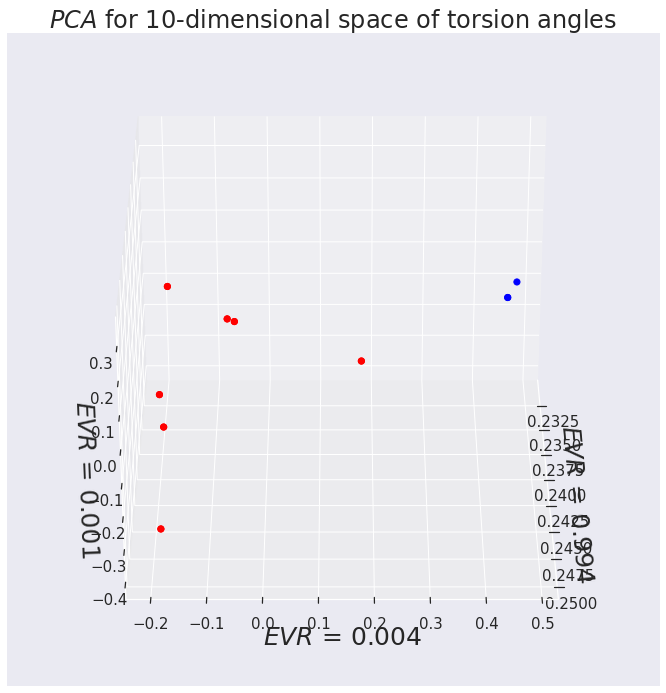

In [87]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.animation as animation

pca = PCA(n_components=3)
res = pca.fit(data.T)

x,y,z = res.components_
xl,yl,zl = res.explained_variance_ratio_

result = pd.DataFrame()
result['x'] = x 
result['y'] = y 
result['z'] = z
result['label'] = labels

fig = plt.figure()

ax = fig.add_subplot(111, projection='3d')
ax.scatter(x,y,z,zdir='z', c=cmap, depthshade=False, s=150, marker='.')

ax.set_xlabel(f'$EVR$ = {xl:.3f}', fontsize = 25)
ax.set_ylabel(f'$EVR$ = {yl:.3f}', fontsize = 25)
ax.set_zlabel(f'$EVR$ = {zl:.3f}', fontsize = 25)
ax.set_title(f'$PCA$ for 10-dimensional space of torsion angles')
ax.tick_params(labelsize=15)

def rotate(angle):
    ax.view_init(azim=angle)

print("Making animation 1")
rot_animation = animation.FuncAnimation(fig, rotate, frames=np.linspace(0,360,180), interval=0.1, repeat=False)
print("Making animation 2")
rot_animation.save('pca.example.gif', dpi=60, writer='imagemagick')

# Clustering

In [88]:
from sklearn.cluster import DBSCAN
epsilon = 40
min_samples = 5

cls = DBSCAN(eps=epsilon, min_samples=min_samples)

X = angles[['psi1', 'phi2','psi2','phi3','psi3','phi4','psi4','phi5','psi5','phi6']].dropna()

X['clusters'] = cls.fit(X).labels_

# Convert to `R`

In [99]:
r_angles = pd.DataFrame(columns=['ID', 'Angle_type', 'Angle_value', 'Type'])
cols = list(angles.columns)[10:]
print(cols)
for col in tqdm(cols):
    temp = angles[['ID','Type', col]].copy()
    temp['Angle_type'] = col
    temp.columns = ['ID', 'Type', 'Angle_value', 'Angle_type']
    r_angles = r_angles.append(temp, ignore_index=True)
r_angles.to_csv('tors_angles.for_R.csv', index=None)

['psi1', 'phi2', 'psi2', 'phi3', 'psi3', 'phi4', 'psi4', 'phi5', 'psi5', 'phi6']


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:00<00:00, 524.56it/s]
